## How to do it...

1. Import required libraries

In [2]:
import numpy as np
import PIL.Image
import imageio
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import IPython.display as display

2. Prepare image to dreamify

Text(0.5, 1.0, 'Original Image')

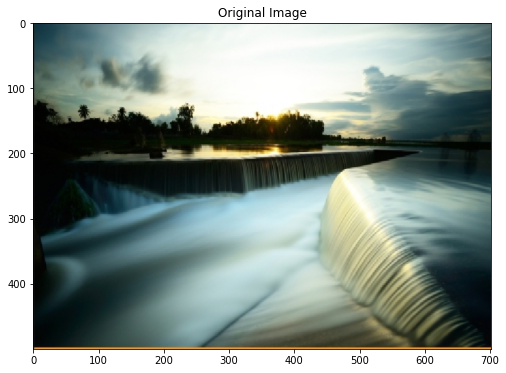

In [5]:
# Read the images
original_img_file = 'book_cover.jpg'
original_img = imageio.imread(original_img_file)

# Reshape to 500 max dimension
new_shape = tf.cast((500, 500 * original_img.shape[1] / original_img.shape[0]), tf.int32)
original_img = tf.image.resize(original_img, new_shape, method='nearest').numpy()

# Display the image
mpl.rcParams['figure.figsize'] = (20, 6)
mpl.rcParams['axes.grid'] = False

plt.imshow(original_img)
plt.title("Original Image")

3. Load the Inception Model

In [6]:
inception_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

4. Summarize the model

In [7]:
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

5. Select the convolutional layers to use for DeepDream processing later

In [8]:
names = ['mixed3', 'mixed5']
layers = [inception_model.get_layer(name).output for name in names]
deep_dream_model = tf.keras.Model(inputs=inception_model.input, outputs=layers)

6. Define loss function

In [9]:
def compute_loss(img, model):
    # Add a dimension to the image to have a batch size 1.
    img_batch = tf.expand_dims(img, axis=0)
    
    # Apply the model to the images and get the outputs to retrieve the activation
    layer_activations = model(img_batch)
    
    # Compute the loss for each layer
    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)
        
        return tf.reduce_sum(losses)

7. Declare two utility functions

In [10]:
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))

8. Apply gradient ascent process

In [11]:
def run_deep_dream(image, steps=100, step_size=0.01):
    # Apply the Inception preprocessing
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    image = tf.convert_to_tensor(image)
    
    loss = tf.constant(0.0)
    for n in tf.range(steps):
        # Use gradient tape to track derivatives
        with tf.GradientTape() as tape:
            tape.watch(image)
            loss = compute_loss(image, deep_dream_model)
            gradients = tape.gradient(loss, image)
            gradients /= tf.math.reduce_std(gradients) + 1e-8
            image = image + gradients*step_size
            image = tf.clip_by_value(image, -1, 1)
            
            # Display intermediate image
            if (n % 100 == 0):
                display.clear_output(wait=True)
                show(deprocess(image))
                print(f'Step {n}, loss {loss}')
                
    result = deprocess(image)
    display.clear_output(wait=True)
    show(result)
    
    return result

9. Run DeepDream on original image

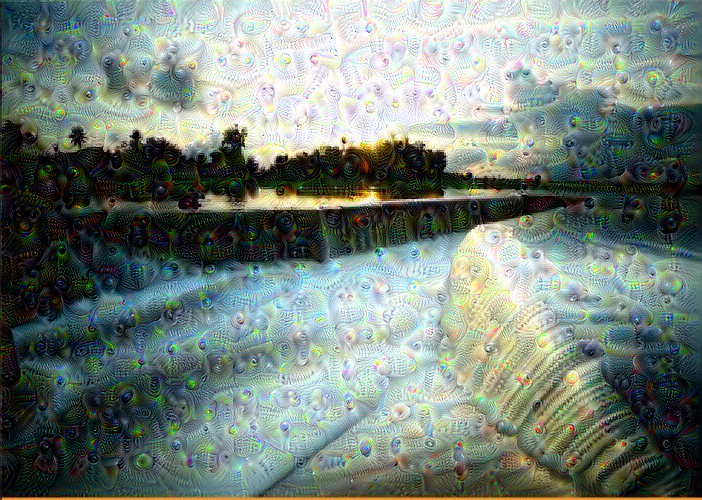

In [12]:
dream_img = run_deep_dream(image=original_img, steps=100, step_size=0.01)

10. Implement octaves concept to improve umage

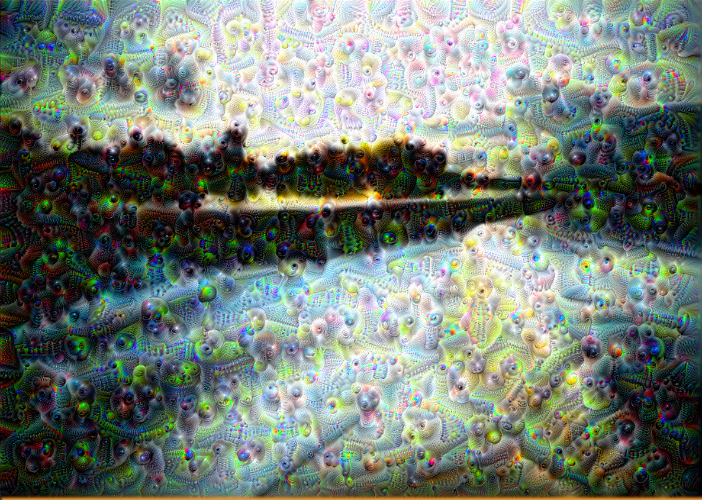

In [13]:
OCTAVE_SCALE = 1.30

image = tf.constant(np.array(original_img))
base_shape = tf.shape(image)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range (-2, 3):
    # Increase the size of the image
    new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)
    image = tf.image.resize(image, new_shape).numpy()
    
    # Apply deep dream
    image = run_deep_dream(image=image, steps=50, step_size=0.01)
    
# Display output
display.clear_output(wait=True)
image = tf.image.resize(image, base_shape)
image = tf.image.convert_image_dtype(image/255.0, dtype=tf.uint8)
show(image)